# Skin Cancer: Malignant vs Benign
This dataset contains a balanced dataset of images of benign skin moles and malignant skin moles.

In [1]:
%matplotlib inline

import os
import gc
from PIL import Image

import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LeakyReLU
from keras.applications import VGG16
from tensorflow import set_random_seed
from sklearn.utils import check_random_state


sns.set()
np.random.seed(0);
set_random_seed(0);
check_random_state(0);

Using TensorFlow backend.


## Content

The data consists of two folders with each 1800 pictures (224x244) of the two types of moles.

In [2]:
# Save the file path of each image and separate them to different classes
#
# Labels:
# 0 -> benign
# 1 -> malignant

train_imgs, test_imgs = [], []
train_labels, test_labels = [], []

for img_path in os.listdir('../input/data/train/benign'):
    train_imgs.append('../input/data/train/benign/' + img_path)
    train_labels.append(0)
    
for img_path in os.listdir('../input/data/train/malignant'):
    train_imgs.append('../input/data/train/malignant/' + img_path)
    train_labels.append(1)
    
for img_path in os.listdir('../input/data/test/benign'):
    test_imgs.append('../input/data/test/benign/' + img_path)
    test_labels.append(0)
    
for img_path in os.listdir('../input/data/test/malignant'):
    test_imgs.append('../input/data/test/malignant/' + img_path)
    test_labels.append(1)
    
train_imgs, test_imgs = np.array(train_imgs), np.array(test_imgs)
train_labels, test_labels = np.array(train_labels), np.array(test_labels)
    
class_distribution = np.bincount(np.concatenate([train_labels, test_labels]))
    
print('Size of train set:', len(train_imgs))
print('Size of test set:', len(test_imgs))
print(class_distribution[0], 'benign labeled samples and', class_distribution[1], 'malignant')

Size of train set: 2637
Size of test set: 660
1800 benign labeled samples and 1497 malignant


## Data selection

Because of the size of the dataset I merge the train and the test sets to slice only 10% of the whole training data as the test set.

Then I slice 7% of the train set to use it for validation.

In [3]:
# Load the images to memory
xtrain, xtest = [], []
ytrain, ytest = train_labels, test_labels

for filename in tqdm.tqdm(train_imgs):
    xtrain.append(np.array(Image.open(filename)))
    
for filename in tqdm.tqdm(test_imgs):
    xtest.append(np.array(Image.open(filename)))
    
del train_imgs, test_imgs, train_labels, test_labels
xtrain, xtest = np.array(xtrain), np.array(xtest)

# Merge and split train and test set to have more train data
data = np.concatenate([xtrain, xtest])
labels = np.concatenate([ytrain, ytest])

# Spliting data to train, validation and test values
xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size=.1, random_state=0)
xtra, xval, ytra, yval = train_test_split(xtrain, ytrain, test_size=.05, random_state=0, shuffle=False)

gc.collect()
print('Shape of the new train set:', xtra.shape)
print('Shape of the new test set:', xtest.shape)
print('Shape of the validation set:', xval.shape)

100%|██████████| 660/660 [00:02<00:00, 243.96it/s]


Shape of the new train set: (2818, 224, 224, 3)
Shape of the new test set: (330, 224, 224, 3)
Shape of the validation set: (149, 224, 224, 3)


Now I generate more training images by changing some of them.

In [4]:
data_generator = ImageDataGenerator(rotation_range=90,
                                    width_shift_range=0.15,
                                    height_shift_range=0.15,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    brightness_range=[0.8, 1.1],
                                    fill_mode='nearest')

new_samples, new_labels = next(data_generator.flow(xtra, ytra, batch_size=len(xtra)))
xtra = np.concatenate([xtra, new_samples])
ytra = np.concatenate([ytra, new_labels])

del new_samples, new_labels
print('New number of training samples:', len(xtra))

New number of training samples: 5636


Use the simple normalization technique where we just divide each pixel value by `255`.

In [5]:
# Normalizing values
xtra = xtra.astype('float32') / 255.
xtest = xtest.astype('float32') / 255.
xval = xval.astype('float32') / 255.

print('Training data shape:', xtra.shape)
print('Min value:', xtra.min())
print('Max value:', xtra.max())

Training data shape: (5636, 224, 224, 3)
Min value: 0.0
Max value: 1.0


## Building and training the model

After this I build a CNN model in keras.

In [6]:
"""
# the commented model
# had 0.83 test accuracy

model.add(Conv2D(32, (3, 3,), activation='relu', input_shape=(224, 224, 3,)))
model.add(Conv2D(32, (3, 3,), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2,)))
model.add(Dropout(.25))
model.add(Conv2D(64, (3, 3,), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3,), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2,)))
model.add(Dropout(.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(1, activation='sigmoid'))
"""

# Build the model
model = Sequential()

model.add(VGG16(include_top=False, input_shape=(224, 224, 3,)))
model.add(Flatten())
model.add(Dense(32))
model.add(LeakyReLU(0.001))
model.add(Dense(16))
model.add(LeakyReLU(0.001))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].trainable = False

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

58892288/58889256 [==============================] - 5s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                802848    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dense_3 (De

Now we can train the model.

In [7]:
# Train the model
N_EPOCHS = 20
h = model.fit(xtra, ytra, validation_data=(xval, yval), epochs=N_EPOCHS, batch_size=64)

Train on 5636 samples, validate on 149 samples
Epoch 1/20
5636/5636 [==============================] - 22s 4ms/step - loss: 0.4571 - acc: 0.7917 - val_loss: 0.3790 - val_acc: 0.8255
Epoch 2/20
5636/5636 [==============================] - 18s 3ms/step - loss: 0.3428 - acc: 0.8497 - val_loss: 0.3552 - val_acc: 0.8322
Epoch 3/20
5636/5636 [==============================] - 18s 3ms/step - loss: 0.2965 - acc: 0.8618 - val_loss: 0.3096 - val_acc: 0.8523
Epoch 4/20
5636/5636 [==============================] - 18s 3ms/step - loss: 0.2811 - acc: 0.8751 - val_loss: 0.3003 - val_acc: 0.8658
Epoch 5/20
5636/5636 [==============================] - 18s 3ms/step - loss: 0.2587 - acc: 0.8799 - val_loss: 0.3302 - val_acc: 0.8389
Epoch 6/20
5636/5636 [==============================] - 18s 3ms/step - loss: 0.2374 - acc: 0.8912 - val_loss: 0.3913 - val_acc: 0.8523
Epoch 7/20
5636/5636 [==============================] - 18s 3ms/step - loss: 0.2460 - acc: 0.8896 - val_loss: 0.2930 - val_acc: 0.8725
Epoch 8/

Visualizing the accuracy and losses to check if the model is overfit.

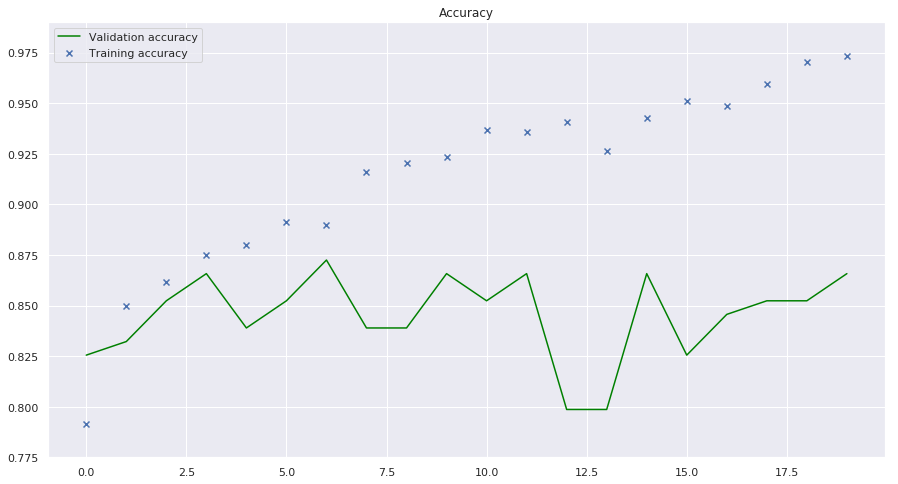

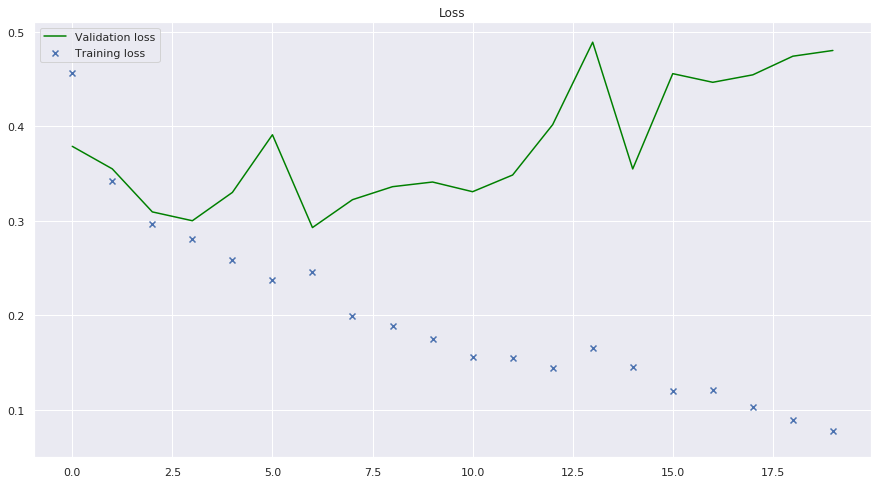

In [8]:
# Plotting accuracy history
plt.figure(figsize=(15, 8))
plt.scatter(range(N_EPOCHS), h.history['acc'], marker='x', label='Training accuracy');
plt.plot(range(N_EPOCHS), h.history['val_acc'], color='green', label='Validation accuracy');
plt.legend();
plt.title('Accuracy');

# Plotting loss history
plt.figure(figsize=(15, 8))
plt.scatter(range(N_EPOCHS), h.history['loss'], marker='x', label='Training loss');
plt.plot(range(N_EPOCHS), h.history['val_loss'], color='green', label='Validation loss');
plt.legend();
plt.title('Loss');

Evaluate the model on test data to double check it's accuracy, and save it to this kernel.

In [9]:
print('Accuracy on test set:', model.evaluate(xtest, ytest)[1])
model.save('model.h5')

330/330 [==============================] - 2s 6ms/step
Accuracy on test set: 0.8969696973309372
